In [ ]:
import os
import pickle
from cedne import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import datetime
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype']=42
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['svg.fonttype'] = 'none'
from typing import Callable, Dict, Any
from scipy.stats import gaussian_kde
from matplotlib.patches import Polygon

In [ ]:
RAND = 42
rng = np.random.default_rng(RAND)
timepoints = 450

In [3]:
today = str(datetime.datetime.now()).split(' ')[0]
outputDir = "Output/" + today + "/"
if not os.path.exists(outputDir):
    os.makedirs(outputDir)

In [ ]:
pickleDir = 'pickles/2025-12-15/'
genotypes = ['N2', 'inx-7-mutant', 'inx-7-rescue']
promoters = ['ncs-1', 'inx-4', 'glr-1', 'acr-5', 'inx-4+mbr-1', 'flp-3p+flp-7p+nmr-1p+sro-1p', 'odr-2(2b)+odr-2(18)p']
stimuli = ['OP-PA-OP', 'OP-Buffer-OP', 'Buffer-PA-Buffer', 'Buffer-Buffer-Buffer', 'OP-gacA-OP']
conditions = ['naive', 'trained']

wormDict = { genotype:{
                    promoter:{
                        stimulus: {
                            condition: {} for condition in conditions
                        } for stimulus in stimuli
                    } for promoter in promoters
                } for genotype in genotypes 
            }

for pf in os.listdir(pickleDir):
    print(pf)
    if not pf.startswith('.'):
        genotype, promoter, stimulus, condition, *name = pf.split('_')
        if not all ([genotype in genotypes, promoter in promoters, stimulus in stimuli, condition in conditions]):
            print(genotype in genotypes, promoter in promoters, stimulus in stimuli, condition in conditions, name)
        else:
            with open(pickleDir + pf, 'rb') as po:
                w = pickle.load(po)
                wormDict[genotype][promoter][stimulus][condition].update({w.name:w})

N2_ncs-1_OP-PA-OP_naive_ncs-1p 20230404 naive-worm3
N2_acr-5_Buffer-PA-Buffer_trained_acr-5p image 20220315trained-worm2
N2_flp-3p+flp-7p+nmr-1p+sro-1p_OP-PA-OP_trained_20240402-ZC4061-trained-OP-PA-30s-worm004
N2_inx-4+mbr-1_OP-PA-OP_naive_inx-4+mbr-1p 20221012 naive-worm2
N2_flp-3p+flp-7p+nmr-1p+sro-1p_Buffer-PA-Buffer_naive_20240116-PA-Buffer-naive-worm3
N2_odr-2(2b)+odr-2(18)p_OP-PA-OP_naive_20250423-ZC4164-Naive-OP-PA-worm004
N2_ncs-1_Buffer-PA-Buffer_trained_ncs-1p 20221107 trained-worm3
N2_ncs-1_OP-gacA-OP_naive_ncs-1p_20240529-naive-OP_gacA_OP-worm004
N2_glr-1_Buffer-PA-Buffer_trained_20211004-ZC3292-PA-Buffer-30s-trained-worm1
N2_flp-3p+flp-7p+nmr-1p+sro-1p_OP-PA-OP_trained_20240402-ZC4061-trained-OP-PA-30s-worm003
N2_ncs-1_OP-PA-OP_naive_ncs-1p 20230404 naive-worm4
N2_inx-4+mbr-1_OP-PA-OP_naive_inx-4+mbr-1p image 20221006naive-worm2
N2_odr-2(2b)+odr-2(18)p_Buffer-PA-Buffer_trained_20250409-ZC4164-trained-PA-Buffer-30s-worm002
N2_ncs-1_Buffer-PA-Buffer_trained_ncs-1p 20221107 

In [ ]:
all_worms = 0
for genotype in wormDict:
    if genotype == 'N2':
        for promoter in wormDict[genotype]:
            for stimulus in wormDict[genotype][promoter]:
                for condition in wormDict[genotype][promoter][stimulus]:
                    nWorms = len(wormDict[genotype][promoter][stimulus][condition])
                    all_worms += nWorms
print(f"Total worms loaded: {all_worms}")
                

Total worms loaded: 919


In [ ]:
all_recordings = 0
for genotype in wormDict:
    if genotype == 'N2':
        for promoter in wormDict[genotype]:
            for stimulus in wormDict[genotype][promoter]:
                for condition in wormDict[genotype][promoter][stimulus]:
                    for worm_name in wormDict[genotype][promoter][stimulus][condition]:
                        worm = wormDict[genotype][promoter][stimulus][condition][worm_name]
                        for cond in worm.networks:
                            nn = worm.networks[cond]
                            all_recs = len(set([k for n in nn.neurons for k in nn.neurons[n].trial.keys()]))
                            all_recordings += all_recs
print(f"Total recordings loaded: {all_recordings}")

Total recordings loaded: 2634


In [8]:
def mm_to_inches(fig_dims):
    fig_width_mm, fig_height_mm = fig_dims
    return (fig_width_mm / 25.4, fig_height_mm / 25.4)

In [9]:
single_column = 90
double_column = 180
max_height = 170
font_size_big = 7 #pts
font_size_mid = 6
font_size_small = 5
dpi = 600


color_stim = {'OP': '#e4ab24',
              'PA': '#1a9d77',
              'Buffer': '#f9f4d7'}
color_conds = {'naive': '#888666',
               'trained': '#6b3e98'}

In [10]:
def full_data_permutation_diff(group1, group2, central_func: Callable = np.median, n_perm: int = 5000, two_sided: bool = True, random_state=None) -> Dict[str, Any]:
    """Permutation test using ALL data (no truncation) on central tendency difference.
    Returns p-value and effect; p-value inherently reflects sample size (more power for large n).
    """
    rng = np.random.default_rng(random_state)
    g1 = np.asarray(group1); g2 = np.asarray(group2)
    g1 = g1[~np.isnan(g1)]; g2 = g2[~np.isnan(g2)]
    if len(g1) == 0 or len(g2) == 0:
        return {'effect': np.nan, 'pval': np.nan, 'n1': len(g1), 'n2': len(g2)}
    obs = central_func(g1) - central_func(g2)
    combined = np.concatenate([g1, g2])
    n1 = len(g1)
    perm_stats = []
    for _ in range(n_perm):
        rng.shuffle(combined)
        perm_stats.append(central_func(combined[:n1]) - central_func(combined[n1:]))
    perm_stats = np.asarray(perm_stats)
    if two_sided:
        pval = (np.sum(np.abs(perm_stats) >= abs(obs)) + 1) / (len(perm_stats) + 1)
    else:
        pval = (np.sum(perm_stats >= obs) + 1) / (len(perm_stats) + 1) if obs >= 0 else (np.sum(perm_stats <= obs) + 1) / (len(perm_stats) + 1)
    return {'effect': obs, 'pval': pval, 'perm_stats': perm_stats, 'n1': len(g1), 'n2': len(g2)}


In [11]:
def get_sig_neurs(trial_dict, trial_dict_names, periods, common_neurs, sample_size, pval_thres=0.05, replace=False):
    sig_neur = {period:[] for period in periods}
    len_ns = {}
    pvals = {}
    len_w = {}
    for period in periods:
        by_neuron_periods = {n: {cond: [] for cond in conditions} for n in common_neurs}
        for cond in conditions:
            if not cond in len_w:
                len_w[cond] = {}
            for w in trial_dict_names[cond][period].keys(): 
                for m, t in zip(trial_dict_names[cond][period][w], trial_dict[cond][period][w]):
                    if m in common_neurs:
                        by_neuron_periods[m][cond].append(t)
                    if not m in len_w[cond]:
                        len_w[cond][m] = []
                    if not w in len_w[cond][m]:
                        len_w[cond][m].append(w)
        
        sig_neur[period] = []
        pvalues = []
        for n in by_neuron_periods:
            # print(n, period, by_neuron_periods[n][conditions[0]])
            # kst = ss.ks_2samp(np.median(np.log(by_neuron_periods[n][conditions[0]]), axis=1), np.median(by_neuron_periods[n][conditions[1]], axis=1))
            medians_naive = np.median(by_neuron_periods[n][conditions[0]], axis=1)
            medians_trained = np.median(by_neuron_periods[n][conditions[1]], axis=1)
            if not replace:
                if not len(medians_naive)>sample_size and len(medians_trained)>sample_size:
                    print(f"Sample size not enough for {n}")
                    continue
            #permt = compare_central_tendency_subsampled(medians_naive, medians_trained, n_subsamples=1000, n_shuffle=100, sample_size=sample_size, central_func=np.mean, replace=replace)
            permt = full_data_permutation_diff(medians_naive, medians_trained, central_func=np.mean, random_state=RAND)
            # kst = ss.ttest_ind(np.mean(by_neuron_periods[n][conditions[0]], axis=1), np.mean(by_neuron_periods[n][conditions[1]], axis=1))
            # print(n, period, kst)
            pvalues.append(permt['pval'])
            # print(n, period, len(by_neuron_periods[n][conditions[0]]), len(by_neuron_periods[n][conditions[1]]), permt['pval'])
            len_ns[n] = min(len(by_neuron_periods[n][conditions[0]]), len(by_neuron_periods[n][conditions[1]]))
        _, pvalues, _, _  = multipletests(pvalues, method='fdr_bh')
        sig_neur[period] = [common_neurs[j] for j in np.where(np.array(pvalues)<pval_thres)[0]]
        pvals[period] = list(zip(common_neurs, pvalues))
    return sig_neur, len_ns, pvals, len_w

In [13]:
def getCombinedName(name):
    if name[-1] in ['L', 'R'] and name not in ['RIR', 'ADL', 'AVL', 'OLL', 'ASEL', 'ASER']:
        return name[:-1]
    else:
        return name

In [14]:
def suffix_periods(periods):
    return [periods[0]+'-pre', periods[1], periods[2]+'-post']

In [ ]:
def return_mat_from_worms_tech_averaged(wormDict, neuron_filter=None, log='False'):
    ''' This one is averaging the technical repeats of the same neuron in the same worm.'''
    fullMat_dict = {cond:[] for cond in conditions}
    neuronName_dict = {cond:[] for cond in conditions}
    wormName_dict = {cond:[] for cond in conditions}
    trial_dict = {cond:{} for cond in conditions}
    trial_dict_names = {cond:{} for cond in conditions}
    stimTimes = [(0,150), (150,300), (300,450)]

    joinLR =True
                        
    for worm in wormDict:
        w = wormDict[worm]
        periods = w.stimulus.split('-')
        periods = suffix_periods(periods)
        for cond in w.networks:
            nn = w.networks[cond]
            for n in nn.neurons:
                if joinLR:
                        m = getCombinedName(n)
                else:
                        m=n
                if neuron_filter is not None and m not in neuron_filter:
                    if hasattr(nn.neurons[n], 'trial'):
                        if len(nn.neurons[n].trial.keys()):
                            ## Merging the focal planes with the same name (technical repeats)
                            tech_repeats = []
                            for k in nn.neurons[n].trial.keys():
                                if np.isnan(nn.neurons[n].trial[k]._data[-1]):
                                        nn.neurons[n].trial[k]._data = nn.neurons[n].trial[k]._data[:-1]
                                        print("Correcting", w.name, n, k)
                                if len(nn.neurons[n].trial[k]._data)>=450:
                                    if not any(np.isnan(nn.neurons[n].trial[k]._data)):
                                        tech_repeats.append(nn.neurons[n].trial[k]._data[:timepoints])
                                else:
                                    print("Check time series array at ", n, len(nn.neurons[n].trial[k]._data))
                            if len(tech_repeats):
                                if len(tech_repeats) > 1:
                                    shapes = [tr.shape for tr in tech_repeats]
                                    if len(set(shapes)) != 1:
                                        raise ValueError(f"Inconsistent shapes in technical repeats: {shapes}")
                                    mean_tech_repeats = np.mean(tech_repeats, axis=0)
                                else:
                                    mean_tech_repeats = tech_repeats[0]
                                
                                if not log:
                                    fullMat_dict[cond].append(mean_tech_repeats)
                                else:
                                    fullMat_dict[cond].append(np.log10(mean_tech_repeats))
                                neuronName_dict[cond].append(m)#nn.neurons[n].name)
                                wormName_dict[cond].append(w.name)
                                for k2, period in enumerate(periods):
                                    if not period in trial_dict[cond]:
                                        trial_dict[cond][period] = {}
                                        trial_dict_names[cond][period] = {}
                                    if not w.name in trial_dict[cond][period]:
                                        trial_dict[cond][period][w.name] = []
                                        trial_dict_names[cond][period][w.name]= []
                                    if not log:
                                        trial_dict[cond][period][w.name].append(mean_tech_repeats[stimTimes[k2][0]:stimTimes[k2][1]])
                                    else:
                                        trial_dict[cond][period][w.name].append(np.log10(mean_tech_repeats[stimTimes[k2][0]:stimTimes[k2][1]]))
                                    trial_dict_names[cond][period][w.name].append(m)#nn.neurons[n].name)
    return fullMat_dict, neuronName_dict, wormName_dict, trial_dict, trial_dict_names

In [17]:
def compute_group_bounds(type_list, normalize=True):
    group_bounds = {}
    current_type = type_list[0]
    start_idx = 0

    for i, t in enumerate(type_list[1:], start=1):
        if t != current_type:
            group_bounds[current_type] = [start_idx, i]
            current_type = t
            start_idx = i
    group_bounds[current_type] = [start_idx, len(type_list)]  # Last group
    if normalize==True:
        for t in group_bounds:
            start, end = group_bounds[t]
            group_bounds[t] = [start / len(type_list), end / len(type_list)]
    return group_bounds

def draw_bracket(ax, y_start, y_end, text=None):
    x = 0.5
    ax.plot([x, x], [y_start, y_end], color='black', lw=2)
    ax.plot([x, x + 0.3], [y_start, y_start], color='black', lw=2)
    ax.plot([x, x + 0.3], [y_end, y_end], color='black', lw=2)
    if text:
        ax.text(x - 0.1, (y_start + y_end) / 2, text, va='center', ha='right', rotation=90, fontsize=30)

def to_sentence_case(text):
    text = text.strip()
    return text[:1].upper() + text[1:].lower() if text else ''

In [19]:
from matplotlib.colors import Normalize
import matplotlib.lines as mlines

genotype_filter = genotypes #['inx-7-rescue', 'inx-7-mutant']#
promoter_filter = promoters
stimulus_filter = stimuli#['Buffer-Buffer-Buffer']
condition_filter = conditions
visual_resolution = 1 #log here
neuron_filter = [] #['RIP', 'URB']
wormDict_cond = {}
log = False
for genotype in wormDict:
    if genotype in genotype_filter:
        wormDict_cond[genotype] = {}
        for promoter in wormDict[genotype]:
            for stimulus in wormDict[genotype][promoter]:
                if not stimulus in wormDict_cond[genotype]:
                    wormDict_cond[genotype][stimulus] = {}
                if genotype in genotype_filter and promoter in promoter_filter and stimulus in stimulus_filter:
                    for condition in conditions:
                        w = wormDict[genotype][promoter][stimulus][condition]
                        wormDict_cond[genotype][stimulus].update(w)

print({genotype:{stimulus:len(w) for stimulus,w in wormDict_cond[genotype].items()} for genotype in wormDict_cond})
wormDict_cond = {genotype:{stimulus:w for stimulus,w in wormDict_cond[genotype].items() if len(w)} for genotype in wormDict_cond}

{'N2': {'OP-PA-OP': 342, 'OP-Buffer-OP': 34, 'Buffer-PA-Buffer': 333, 'Buffer-Buffer-Buffer': 103, 'OP-gacA-OP': 40}, 'inx-7-mutant': {'OP-PA-OP': 33, 'OP-Buffer-OP': 0, 'Buffer-PA-Buffer': 0, 'Buffer-Buffer-Buffer': 0, 'OP-gacA-OP': 0}, 'inx-7-rescue': {'OP-PA-OP': 34, 'OP-Buffer-OP': 0, 'Buffer-PA-Buffer': 0, 'Buffer-Buffer-Buffer': 0, 'OP-gacA-OP': 0}}


# Fig. 1f,g; Extended Data Fig. 4a,b,c,j,k

N2 OP-PA-OP
{'naive': ['ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm4', 'ncs-1p 20230404 naive-worm4', 'ncs-1p 20230404 naive-worm4', 'ncs-1p 20230404 naive-worm4', 'ncs-1p 20230404 naive-worm4', 'ncs-1p 20230404 naive-worm4', 'ncs-1p 20230404 naive-worm4', 'ncs-1p 20230404 naive-worm4', 'ncs-1p 20230404 naive-worm4', 'ncs-1p 20230404 naive-worm4', 'ncs-1p 20230404 naive-worm4', 'ncs-1p 20230404 naive-worm4', 'ncs-1p 20230404

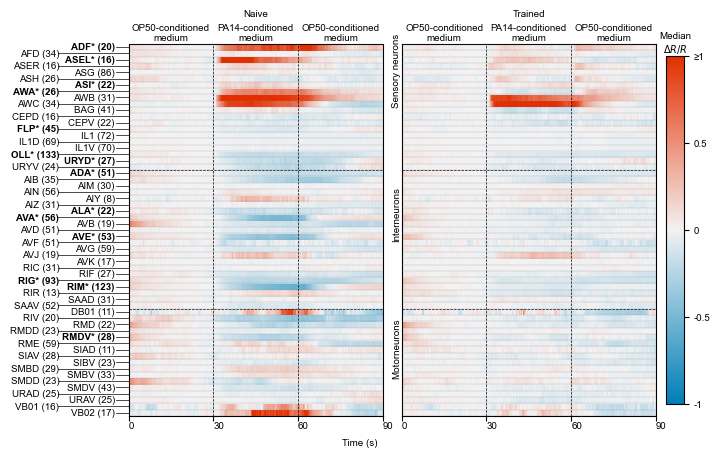

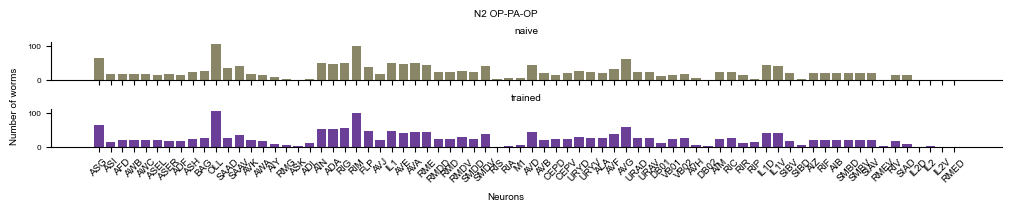

naive
ASG:66
ASI:18
AFD:19
AWB:19
AWC:19
ASEL:16
ASER:17
ADF:14
ASH:25
BAG:26
OLL:106
SAAD:36
SAAV:40
AVK:17
AWA:16
AIY:10
RMG:4
ASK:2
ADL:5
AIN:51
ADA:48
RIG:49
RIM:100
FLP:39
AVJ:19
IL1:49
AVE:47
AVA:49
RME:45
RMDD:24
RMD:25
RMDV:28
SMDD:24
SMDV:40
RIS:5
RIA:7
M1:6
AVD:44
AVB:22
CEPD:16
CEPV:22
URYD:27
URYV:24
ALA:22
AVF:34
AVG:61
URAD:25
URAV:25
DB01:13
VB01:16
VB02:17
AVH:6
DB02:2
AIM:23
RIC:24
RIR:14
RIP:5
IL1D:43
IL1V:42
SIBV:22
SIBD:5
AIZ:21
RIF:21
AIB:21
SMBD:22
SMBV:22
SIAV:22
RMEV:2
RIV:14
SIAD:14
IL2D:1
IL2:1
IL2V:1
RMED:1
trained
ASG:64
ASI:15
AFD:20
AWA:18
AWB:20
AWC:20
ASEL:19
ADL:12
BAG:27
OLL:104
SAAD:27
SAAV:36
AVK:20
ASK:2
ASER:16
ADF:17
ASH:24
AIY:8
RMG:7
FLP:46
AIN:51
ADA:52
RIG:54
AVJ:20
RIM:98
IL1:47
IL2:3
RIP:14
AVD:43
AVE:42
AVB:19
AVA:44
RME:43
RMDD:23
RMD:22
RMDV:28
SMDD:23
SMDV:37
RIA:4
M1:5
RIS:1
CEPD:22
CEPV:24
URYD:28
URYV:27
ALA:26
AVF:37
AVH:6
AVG:59
URAD:27
URAV:26
DB01:11
VB01:22
VB02:25
DB02:2
AIM:24
RIC:25
RIR:13
IL1D:40
IL1V:40
SIBV:17
SIBD:7
AIZ:21

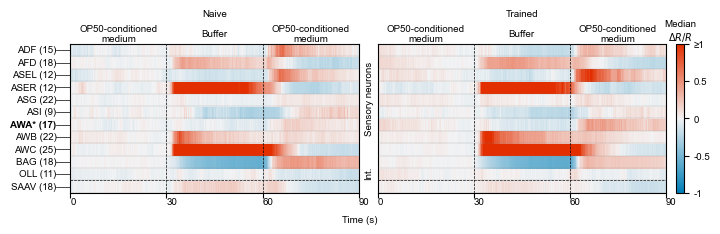

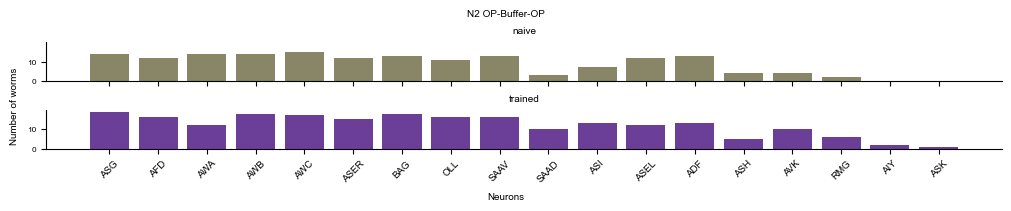

naive
ASG:14
AFD:12
AWA:14
AWB:14
AWC:15
ASER:12
BAG:13
OLL:11
SAAV:13
SAAD:3
ASI:7
ASEL:12
ADF:13
ASH:4
AVK:4
RMG:2
trained
ASG:19
ASI:13
AWB:18
ASEL:12
BAG:18
OLL:16
SAAV:16
SAAD:10
AVK:10
AFD:16
AWA:12
AWC:17
ASER:15
ADF:13
RMG:6
ASH:5
AIY:2
ASK:1
N2 Buffer-PA-Buffer
Correcting 20210927-ZC3292-PA-Buffer-30s-naive-worm4 RIM 2
Check time series array at  RIM 449
{'naive': ['ncs-1p 20221102 naive-worm1', 'ncs-1p 20221102 naive-worm1', 'ncs-1p 20221102 naive-worm1', 'ncs-1p 20221102 naive-worm1', 'ncs-1p 20221102 naive-worm1', 'ncs-1p 20221102 naive-worm1', 'ncs-1p 20221102 naive-worm1', 'ncs-1p 20221102 naive-worm1', 'ncs-1p 20221103 naive-worm2', 'ncs-1p 20221103 naive-worm2', 'ncs-1p 20221103 naive-worm2', 'ncs-1p 20221103 naive-worm2', 'ncs-1p 20221103 naive-worm2', 'ncs-1p 20221103 naive-worm2', 'ncs-1p 20221103 naive-worm2', 'ncs-1p 20221103 naive-worm2', 'ncs-1p 20221103 naive-worm2', 'ncs-1p 20221103 naive-worm2', 'ncs-1p 20221103 naive-worm2', 'ncs-1p 20221103 naive-worm2', 'nc

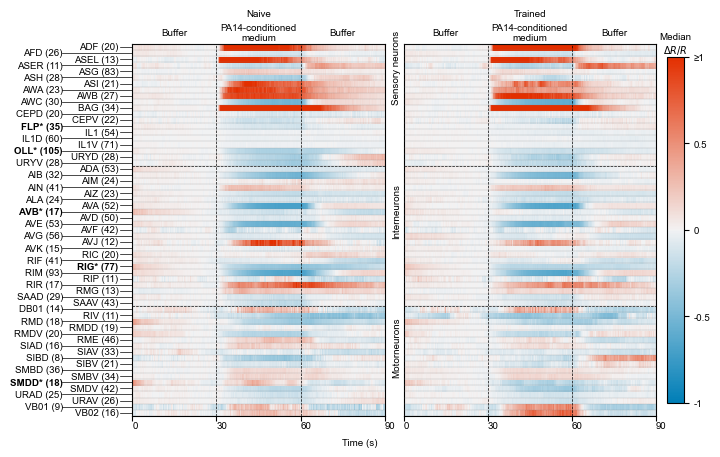

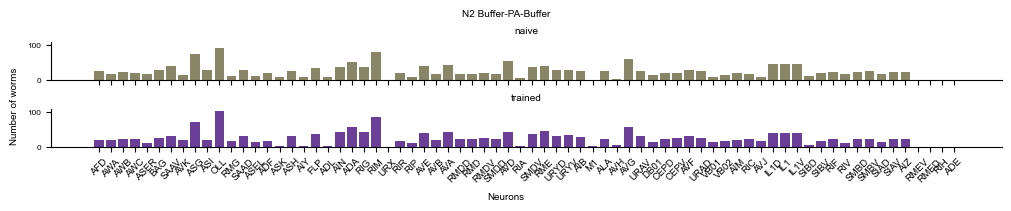

naive
AFD:25
AWA:19
AWB:23
AWC:22
ASER:18
BAG:28
SAAV:41
AVK:15
ASG:75
ASI:29
OLL:91
RMG:13
SAAD:28
ASEL:13
ADF:20
ASK:8
ASH:25
AIY:10
FLP:34
ADL:9
AIN:39
ADA:52
RIG:39
RIM:80
URX:1
RIR:21
RIP:10
AVE:41
AVB:17
AVA:43
RMDD:19
RMD:18
RMDV:20
SMDD:18
AVD:55
RIA:6
SMDV:37
RME:41
URYD:28
URYV:28
AIB:25
M1:1
ALA:27
AVH:4
AVG:62
URAV:26
DB01:14
CEPD:20
CEPV:22
AVF:28
URAD:25
VB01:9
VB02:16
AIM:20
RIC:18
AVJ:10
IL1D:47
IL1:45
IL1V:47
SIBD:11
SIBV:21
RIF:24
RIV:17
SMBD:24
SMBV:25
SIAD:18
SIAV:24
AIZ:23
RMEV:2
RMED:1
trained
ASG:71
AFD:21
AWA:19
AWB:24
AWC:24
ASER:11
ADF:18
BAG:25
OLL:104
SAAV:32
ASI:20
SAAD:30
AVK:19
RMG:16
ASH:30
ASEL:15
AIY:4
ASK:3
FLP:38
ADL:4
AIN:44
ADA:58
RIG:44
RIM:86
AVJ:17
RIR:17
AVE:41
AVB:21
AVA:42
RMDD:23
RMD:23
RMDV:27
SMDD:23
SMDV:38
AVD:44
RIA:4
RME:46
URYD:30
URYV:33
M1:3
AIB:28
CEPV:27
ALA:24
URAD:26
URAV:30
CEPD:23
AVF:30
AVG:56
DB01:14
VB01:14
VB02:16
AVH:6
AIM:21
RIC:23
RIP:12
RIH:1
ADE:1
IL1D:41
IL1:39
IL1V:41
SIBV:17
SIBD:7
AIZ:23
RIF:22
RIV:10
SMBD:24
SMBV

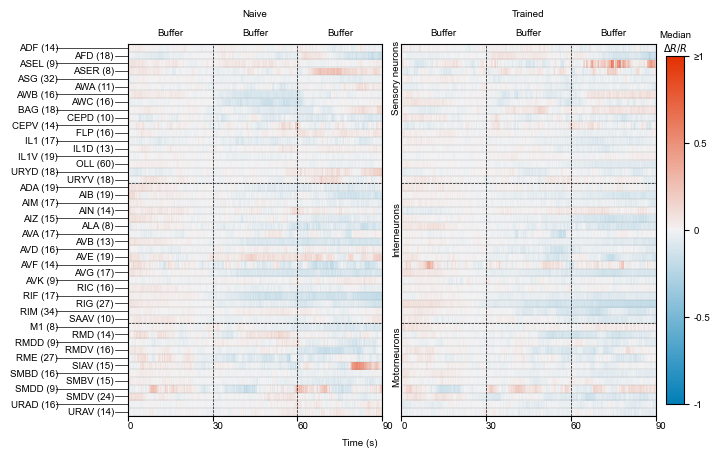

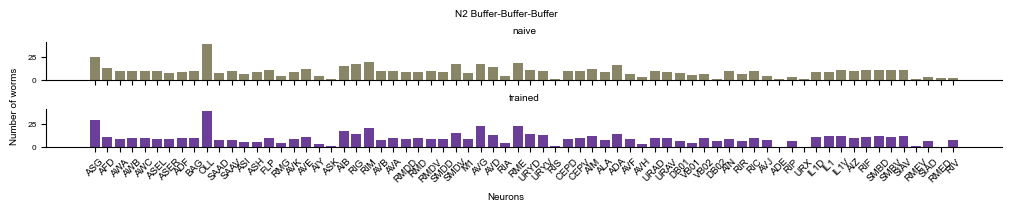

naive
ASG:25
AFD:13
AWA:10
AWB:10
AWC:10
ASEL:10
ASER:8
ADF:9
BAG:10
OLL:39
SAAD:8
SAAV:10
ASI:7
ASH:9
FLP:11
RMG:4
AVK:9
AVE:12
AIY:5
ASK:1
AIB:15
RIG:17
RIM:20
AVB:10
AVA:10
RMDD:9
RMD:9
RMDV:10
SMDD:9
SMDV:17
M1:8
AVG:17
AVD:14
RIA:4
RME:18
URYD:11
URYV:10
RIS:1
CEPD:10
CEPV:10
AIM:12
ALA:9
ADA:16
AVF:7
AVH:3
URAD:10
URAV:9
DB01:8
VB01:6
VB02:7
DB02:1
AIN:10
RIR:7
RIC:10
AVJ:5
ADE:1
RIP:3
URX:1
IL1D:9
IL1:9
IL1V:11
AIZ:10
RIF:11
SMBD:11
SMBV:11
SIAV:11
RMEV:1
SIAD:3
RMED:2
RIV:2
trained
ASG:29
AFD:11
AWA:9
AWB:10
AWC:10
ASEL:9
ASER:9
ADF:10
BAG:10
OLL:39
SAAD:7
SAAV:8
AVK:9
ASK:1
ASH:5
RMG:4
ASI:5
AIY:3
AVE:11
URYD:14
URYV:13
AIB:17
RIG:14
AVD:13
RIM:20
AVB:8
AVA:10
RME:22
RMDD:9
RMD:10
RMDV:9
SMDD:9
SMDV:15
M1:9
RIS:1
AVG:23
AVJ:7
RIA:4
CEPD:9
CEPV:10
ALA:8
AVH:3
URAD:10
URAV:10
DB02:6
VB01:4
VB02:10
AVF:9
AIM:12
DB01:6
ADA:14
FLP:10
AIN:9
RIC:10
RIP:6
RIR:6
IL1D:11
IL1:12
IL1V:12
AIZ:10
RIF:11
RIV:7
SMBD:12
SMBV:11
SIAV:12
SIAD:6
RMEV:1
N2 OP-gacA-OP
{'naive': ['ncs-1p_20240529-na

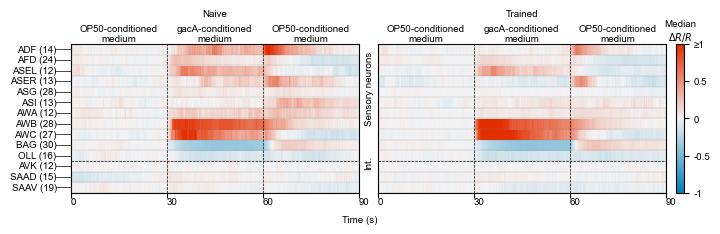

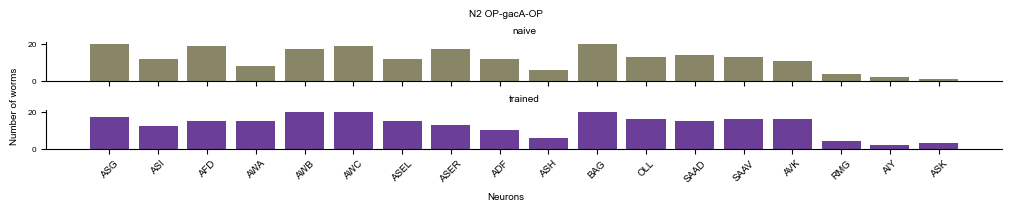

naive
ASG:20
ASI:12
AFD:19
AWA:8
AWB:17
AWC:19
ASEL:12
ASER:17
ADF:12
ASH:6
BAG:20
OLL:13
SAAD:14
SAAV:13
AVK:11
RMG:4
AIY:2
ASK:1
trained
ASG:17
AFD:15
AWB:20
AWC:20
ASEL:15
ASER:13
ADF:10
BAG:20
SAAD:15
AVK:16
AWA:15
ASH:6
OLL:16
SAAV:16
ASI:12
RMG:4
ASK:3
AIY:2
inx-7-mutant OP-PA-OP
{'naive': ['20241204-ZC4255-naive-OP-PA-30s-worm001', '20241204-ZC4255-naive-OP-PA-30s-worm001', '20241204-ZC4255-naive-OP-PA-30s-worm001', '20241204-ZC4255-naive-OP-PA-30s-worm001', '20241204-ZC4255-naive-OP-PA-30s-worm001', '20241204-ZC4255-naive-OP-PA-30s-worm001', '20241204-ZC4255-naive-OP-PA-30s-worm001', '20241204-ZC4255-naive-OP-PA-30s-worm001', '20241204-ZC4255-naive-OP-PA-30s-worm001', '20241204-ZC4255-naive-OP-PA-30s-worm001', '20241204-ZC4255-naive-OP-PA-30s-worm001', '20241126-ZC4255-naive-OP-PA-30s-worm01', '20241126-ZC4255-naive-OP-PA-30s-worm01', '20241126-ZC4255-naive-OP-PA-30s-worm01', '20241126-ZC4255-naive-OP-PA-30s-worm01', '20241126-ZC4255-naive-OP-PA-30s-worm01', '20241126-ZC4255-na

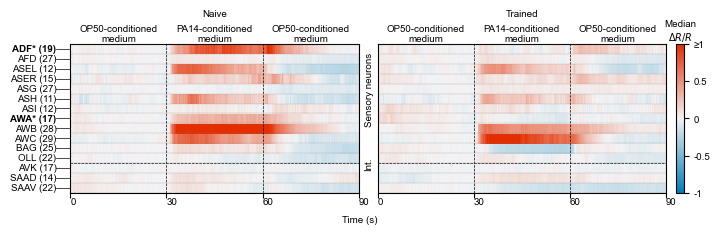

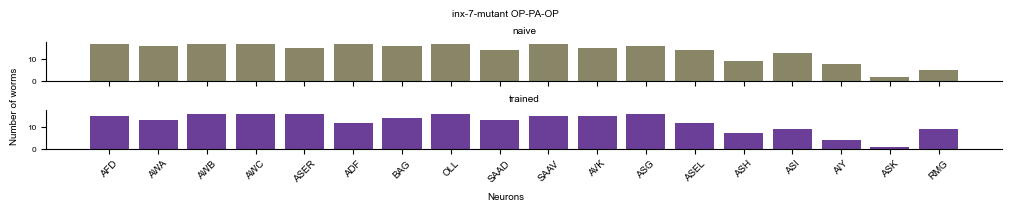

naive
AFD:17
AWA:16
AWB:17
AWC:17
ASER:15
ADF:17
BAG:16
OLL:17
SAAD:14
SAAV:17
AVK:15
ASG:16
ASEL:14
ASH:9
ASI:13
AIY:8
ASK:2
RMG:5
trained
ASG:16
ASI:9
AFD:15
AWA:13
AWB:16
AWC:16
ASEL:12
ASER:16
ADF:12
ASH:7
BAG:14
OLL:16
SAAD:13
SAAV:15
AVK:15
AIY:4
RMG:9
ASK:1
inx-7-rescue OP-PA-OP
{'naive': ['20250507-ZC4251-naive-OP-PA-30s-worm001', '20250507-ZC4251-naive-OP-PA-30s-worm001', '20250507-ZC4251-naive-OP-PA-30s-worm001', '20250507-ZC4251-naive-OP-PA-30s-worm001', '20250507-ZC4251-naive-OP-PA-30s-worm001', '20250507-ZC4251-naive-OP-PA-30s-worm001', '20250507-ZC4251-naive-OP-PA-30s-worm001', '20250507-ZC4251-naive-OP-PA-30s-worm001', '20250507-ZC4251-naive-OP-PA-30s-worm001', '20250507-ZC4251-naive-OP-PA-30s-worm001', '20250507-ZC4251-naive-OP-PA-30s-worm001', '20250507-ZC4251-naive-OP-PA-30s-worm001', '20250507-ZC4251-naive-OP-PA-30s-worm001', '20250507-ZC4251-naive-OP-PA-30s-worm001', '20250507-ZC4251-naive-OP-PA-30s-worm001', '20250507-ZC4251-naive-OP-PA-30s-worm001', '20250507-ZC42

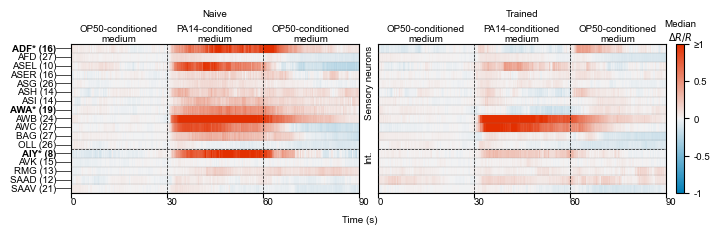

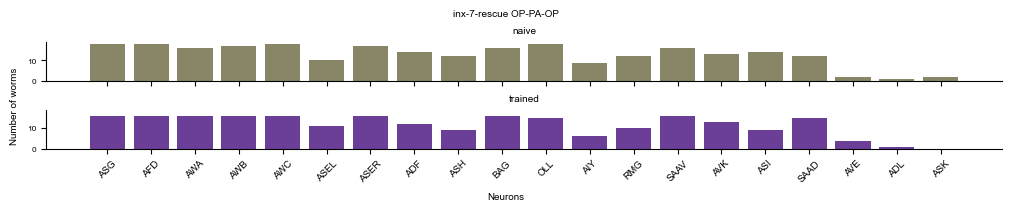

naive
ASG:18
AFD:18
AWA:16
AWB:17
AWC:18
ASEL:10
ASER:17
ADF:14
ASH:12
BAG:16
OLL:18
AIY:9
RMG:12
SAAV:16
AVK:13
ASI:14
SAAD:12
AVE:2
ADL:1
ASK:2
trained
ASG:16
ASI:9
AFD:16
AWA:16
AWB:16
AWC:16
ASER:16
ADF:12
BAG:16
OLL:15
RMG:10
SAAD:15
SAAV:16
AVK:13
ASH:9
ASEL:11
AIY:6
ADL:1
AVE:4


In [ ]:
%matplotlib inline
neuron_class = {}
wormname = list(wormDict_cond['N2']['OP-PA-OP'].keys())[0]
nn_unfolded = wormDict_cond['N2']['OP-PA-OP'][wormname].networks['naive']

for n in nn_unfolded.neurons:
    if n[-1] in ['L', 'R'] and n not in ['RIR', 'ADL', 'AVL', 'OLL', 'ASEL', 'ASER']:
        classname = n[:-1]
        if not classname in neuron_class:
            neuron_class[classname] = []
        neuron_class[classname].append(n)

nn = nn_unfolded.fold_network(neuron_class, exceptions=['ASEL', 'ASER'], self_loops=False, data='clean')

neuron_type_sorting = {'sensory':0, 'interneuron':1, 'motorneuron':2}

xlabel_offset = 0.1  
short_tick = 0.05
long_tick = 0.28
seperator_linewidth = 0.5
tick_linewidth = 0.5
ntype_label = {'sensory': 'Sensory neurons', 'interneuron': 'Interneurons', 'motorneuron': 'Motorneurons'}
ntype_label_short = {'sensory': 'Sensory neurons', 'interneuron': 'Int.', 'motorneuron': 'Mot.'} 
period_label = { 'OP': 'OP50-conditioned\nmedium', 'PA': 'PA14-conditioned\nmedium', 'gacA':'gacA-conditioned\nmedium', 'Buffer':'Buffer'}
short_stim_pos = 1.07
long_stim_pos = 1.03
num_threshold = 7
num_bootstrap_samples = 15
pval_thres = 0.05
replace_for_bootstrap = True
saturation = 100
lightness = 50
hneg = 240
hpos = 15
significant_neurons_all = {}
neurons_all = {}
for genotype in wormDict_cond:
    significant_neurons_all[genotype] = {}
    neurons_all[genotype] = {}
    for stimulus in wormDict_cond[genotype]:

        print(genotype, stimulus)
        fullMat_dict, neuronName_dict, wormName_dict, trial_dict, trial_dict_names = return_mat_from_worms_tech_averaged(wormDict_cond[genotype][stimulus], neuron_filter=neuron_filter, log=log)
        print(wormName_dict)
        by_neuron_trials = {cond: {} for cond in conditions}
        both_neuronsets = []
        for cond in conditions:
            nlabels = set(neuronName_dict[cond])
            both_neuronsets.append(nlabels)
            by_neuron_trials[cond] =  {n:[] for n in nlabels}
            for n,t in zip(neuronName_dict[cond], fullMat_dict[cond]):
                by_neuron_trials[cond][n].append(t)
            
        common_neurs = list(both_neuronsets[0].intersection(both_neuronsets[1]))


        # Use Arial-like fonts in math mode
        plt.rcParams["mathtext.fontset"] = "dejavusans"  # Closest built-in match to Arial
        plt.rcParams["mathtext.rm"] = "Arial"  # Regular text in math mode
        plt.rcParams["mathtext.bf"] = "Arial"  # Bold text in math mode
        plt.rcParams.update({'font.family': 'DejaVu Sans', 'font.size': font_size_mid})  # Choose any font and size
        
        periods = stimulus.split('-')
        suffixed_periods = suffix_periods(periods)
        effective_periods = [suffixed_periods[1], suffixed_periods[2]]

        sig_neur, len_ns, pvals, len_w = get_sig_neurs(trial_dict, trial_dict_names, effective_periods, common_neurs, sample_size=num_bootstrap_samples, pval_thres=pval_thres, replace=replace_for_bootstrap)
        by_neuron_trials_list = {cond:[] for cond in conditions}
        cscheme = "RdBu_r"
        plt.rcParams["font.family"] = "Arial"
        color_conditions = {'naive':'gray', 'trained':'orange'}
        cmap = sns.diverging_palette(hneg, hpos, s=saturation, l=lightness, as_cmap=True)
        significant_neurons = [q for p in effective_periods for q in sig_neur[p]]
        print(significant_neurons)
        print(pvals)

        significant_neurons_all[genotype][stimulus] = significant_neurons

        nlabels_pre = [n for n in common_neurs if len_ns[n]>num_threshold]
        nlabels = sorted(nlabels_pre, key=lambda n:(neuron_type_sorting[nn.neurons[n].type], n), reverse=True)
        print(len(nlabels))
        print(common_neurs, len_ns)
        neurons_all[genotype][stimulus] = nlabels
        nlabel_types = [nn.neurons[n].type for n in nlabels]
        group_bounds = compute_group_bounds(nlabel_types, normalize=False)

        if len(nlabels)>20:
            short_fig =False
            figsize = mm_to_inches((double_column, max_height*2/3))
        else:
            short_fig = True
            figsize = mm_to_inches((double_column, max_height*1/3)) 
        fig, ax = plt.subplots(figsize=figsize, ncols=2, sharex=True, sharey=True, layout='constrained')

        for i,cond in enumerate(conditions):
            for n in nlabels:
                by_neuron_trials_list[cond].append(np.median(by_neuron_trials[cond][n], axis=0))
            
            vm = visual_resolution
            norm= Normalize(-vm,vm)
            cbar = ax[i].pcolor(by_neuron_trials_list[cond],  cmap=cmap, norm=norm) #vmin=-vm, vmax=vm,
            for x in [150,300]:
                ax[i].axvline(x=x, linestyle='--', color='k', linewidth=seperator_linewidth)
            yticks = np.arange(len(nlabels))+0.5
            ax[i].set_yticks(yticks)
            ax[i].set_yticklabels([])

            if not short_fig:
                tick_lengths = [short_tick if i%2==0 else long_tick for i in range(len(yticks))]
                label_pad = [10 if i%2==0 else 50 for i in range(len(yticks))]  # Adjust pad values as needed 
                stim_pos = long_stim_pos
            else:
                tick_lengths = [short_tick for _ in range(len(yticks))]
                label_pad = [10 for _ in range(len(yticks))]
                stim_pos = short_stim_pos

            for j,nl in enumerate(nlabels):
                # Label formatting with significance marker
                neuron_label = f'{nl}*' if nl in significant_neurons else f'{nl}'
                is_bold = True if nl in significant_neurons else False
                worm_count = f'({len_ns[nl]})'

                # Main label
                if i == 0:  # Only add worm count once, on left subplot
                    ax[i].annotate(f'{neuron_label} {worm_count}', xy=(0, j + 0.5), xycoords='data',
                                xytext=(-label_pad[j], 0), textcoords='offset points',
                                ha='right', va='center', fontsize=font_size_big, fontweight='bold' if is_bold else 'normal')
                    y, length = yticks[j], tick_lengths[j]
                    tick = mlines.Line2D([-length, 0], [y, y], transform=ax[i].get_yaxis_transform(),
                            color='black', linewidth=tick_linewidth, clip_on=False)
                    ax[i].add_line(tick)

            # Remove default ticks
            ax[i].tick_params(axis='y', length=0)

            # Custom tick lengths based on spacing
            # Draw custom ticks manually
            ax[i].set_xticks([0,150,300,450], [0,30,60,90], fontsize=font_size_big)
            ax[i].tick_params(axis='x', which='major', pad=0)
            for label in ax[i].get_xticklabels():
                label.set_horizontalalignment('left')
                label.set_x(label.get_position()[0] + xlabel_offset)

            ax[i].set_title(to_sentence_case(cond), fontsize=font_size_big, loc="center", pad=20)  #, color=color_conditions[cond]
            for p, pname in zip([(0,150), (150,300), (300,450)], [f'{periods[0]}', f'{periods[1]}', f'{periods[2]}']):
                per_lab = period_label[pname]
                ax[i].text(
                    ((p[0]+p[1])/2)/450, stim_pos, s=f'{per_lab}',
                    fontsize=font_size_big, ha='center', va='center',
                    transform=ax[i].transAxes,
                    clip_on=False  # prevents clipping of labels
                )
            for ntype in group_bounds:
                ax[i].axhline(y=group_bounds[ntype][1], color='k', linewidth=seperator_linewidth, linestyle='--')

        group_bounds = compute_group_bounds(nlabel_types, normalize=True)
        y0 = ax[0].get_position().y0
        y1 = ax[0].get_position().y1 
        x1 = ax[0].get_position().x1
        x2 = ax[1].get_position().x0
        # x_position = x1 + 0.16*x1
        if not short_fig:
            x_position = ((x1 + x2)/2) *1.075
        else:
            x_position = ((x1 + x2)/2)
            
        total_rows = len(nlabels)

        for ntype in group_bounds:
            start, end = group_bounds[ntype]
            midpoint = (start + end) / 2
            frac = midpoint / total_rows
            midpoint_within_axis = (0, midpoint + 0.5)  # +0.5 to hit cell center

            
            if not short_fig:
                midpoint_norm = (midpoint + y0)/1.1
                fig.text(x_position, midpoint_norm, ntype_label[ntype], ha='center', va='center', rotation=90, fontsize=font_size_big)
            else:
                midpoint_norm = ((midpoint + y0)/1.5 +0.15)
                fig.text(x_position, midpoint_norm, ntype_label_short[ntype], ha='center', va='center', rotation=90, fontsize=font_size_big)

        for ax_ in ax:
            for y in range(total_rows + 1):  # include bottom line
                ax_.axhline(y=y, xmin=0, xmax=450, color='gray', linewidth=0.3, alpha=0.5, zorder=10)
        fig.supxlabel("Time (s)",fontsize=font_size_big)


        cbar = fig.colorbar(cbar, ax=ax.ravel().tolist(), orientation='vertical', fraction=0.033, pad=0)
        cbar.ax.tick_params(labelsize=font_size_big)
        cbar.ax.set_yticks([-1,-0.5,0,0.5,1], ['-1','-0.5','0','0.5','≥1'])
        cbar.ax.set_title("Median\n$\\Delta R / R$", fontsize=font_size_big, pad=3)
        
        plt.savefig(f'{outputDir}{genotype}_{stimulus}_neurons.svg', dpi=dpi, bbox_inches='tight', transparent=True)
        plt.show()

        for i,cond in enumerate(conditions):
            print(cond)
            neurs, nums = zip(*len_w[cond].items())
            for n, num in zip(neurs, [len(set(num)) for num in nums]):
                print(f"{n}:{num}")


# Statisically active

In [ ]:
def statisticallyActive(neuron_trials, boundaries=(150, 300), window=(50,150), measure='median', test='wilcoxon-hybrid'):
    ''' Is the trial showing an active neuron?'''
    neuron_trials = np.array(neuron_trials)

    first_window_left = neuron_trials[:,boundaries[0]-window[0]:boundaries[0]]
    first_window_right = neuron_trials[:,boundaries[0]:boundaries[0]+window[1]]
    second_window_left = neuron_trials[:,boundaries[1]-window[0]:boundaries[1]]
    second_window_right = neuron_trials[:,boundaries[1]:boundaries[1]+window[1]]

    if measure == 'median':
        fw_lm  = np.nanmedian(first_window_left, axis=1)
        fw_rm  = np.nanmedian(first_window_right, axis=1)
        sw_lm = np.nanmedian(second_window_left, axis=1)
        sw_rm  = np.nanmedian(second_window_right, axis=1)
    else:
        raise TypeError(f"Invalid measure {measure}")

    first_window_sign = np.sign(np.median(fw_rm))>0
    second_window_sign = np.sign(np.median(sw_rm-sw_lm))>0
    if test == 'wilcoxon-hybrid':
        stats_first_window = ss.wilcoxon(fw_lm, fw_rm) 
        stats_second_window= ss.wilcoxon(sw_lm, sw_rm)

    else:
        raise TypeError("Invalid test")

    pvalue_first_window = stats_first_window.pvalue
    pvalue_second_window = stats_second_window.pvalue

    return (fw_lm, fw_rm, pvalue_first_window, first_window_sign), (sw_lm, sw_rm, pvalue_second_window, second_window_sign)

In [ ]:
active_neurons = {}
windows = (50,150)
measure = 'mean'
test = 'wilcoxon-hybrid'
fw_list = []

for genotype in wormDict_cond:
    active_neurons[genotype] = {}
    for stimulus in wormDict_cond[genotype]:
        active_neurons[genotype][stimulus] = {}
        print(genotype, stimulus)
        fullMat_dict, neuronName_dict, wormName_dict, trial_dict, trial_dict_names = return_mat_from_worms_tech_averaged(wormDict_cond[genotype][stimulus], neuron_filter=neuron_filter, log=False)
        print(wormName_dict)
        by_neuron_trials = {cond: {} for cond in conditions}
        both_neuronsets = []
        for cond in conditions:
            nlabels = set(neuronName_dict[cond])
            both_neuronsets.append(nlabels)
            by_neuron_trials[cond] =  {n:[] for n in nlabels}
            for n,t in zip(neuronName_dict[cond], fullMat_dict[cond]):
                if not any(np.isnan(t)):
                    by_neuron_trials[cond][n].append(t)
    
        for cond in by_neuron_trials:
            active_neurons[genotype][stimulus][cond] = {}
            for n in by_neuron_trials[cond]:
                if n in by_neuron_trials['naive'] and n in by_neuron_trials['trained']:
                    if len(by_neuron_trials['naive'][n])>num_threshold and len(by_neuron_trials['trained'][n])>num_threshold :
                        first_window, second_window = statisticallyActive(by_neuron_trials[cond][n], window=windows, measure=measure, test=test)
                        fw_list+=list(first_window[0])
                        active_neurons[genotype][stimulus][cond][n] = (first_window, second_window)

N2 OP-PA-OP
{'naive': ['ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm3', 'ncs-1p 20230404 naive-worm4', 'ncs-1p 20230404 naive-worm4', 'ncs-1p 20230404 naive-worm4', 'ncs-1p 20230404 naive-worm4', 'ncs-1p 20230404 naive-worm4', 'ncs-1p 20230404 naive-worm4', 'ncs-1p 20230404 naive-worm4', 'ncs-1p 20230404 naive-worm4', 'ncs-1p 20230404 naive-worm4', 'ncs-1p 20230404 naive-worm4', 'ncs-1p 20230404 naive-worm4', 'ncs-1p 20230404 naive-worm4', 'ncs-1p 20230404

In [ ]:
def half_violinplot(ax, data, position, side='right', width=0.8, bw_method=None,
                    color='C0', alpha=0.6, edgecolor='black', num_threshold=3):
    data = np.asarray(data)
    data = data[~np.isnan(data)]
    if len(data) < num_threshold:
        return 0,0  # nothing drawn, return 0 height
    kde = gaussian_kde(data, bw_method=bw_method)
    ymin, ymax = data.min(), data.max()
    y = np.linspace(ymin, ymax, 200)
    density = kde(y)
    density = density / density.max() * (width / 2)

    x = position + density if side == 'right' else position - density
    verts = np.column_stack([x, y])
    verts = np.concatenate([
        [[position, y[0]]],
        verts,
        [[position, y[-1]]]
    ])
    poly = Polygon(verts, facecolor=color, edgecolor=edgecolor, alpha=alpha)
    ax.add_patch(poly)

    return y.min(), y.max()  # return actual y limit

def plot_valence_split_violin(active_neurons, genotype, stimulus, periods, measure='', save=False, pval_thres=0.05):

    ods = stimulus.split('-')
    if ods[0] == 'OP':
        ods[0] = 'OP50'
    elif ods[0] == 'PA':
        ods[0] = 'PA14'
    elif ods[0] == 'gacA':
        ods[1] = 'PA14-$\\it{gacA(-)}$'

    if ods[1] == 'OP':
        ods[1] = 'OP50'
    elif ods[1] == 'PA':
        ods[1] = 'PA14'
    elif ods[1] == 'gacA':
        ods[1] = 'PA14-$\\it{gacA(-)}$'
        
    if ods[2] == 'OP':
        ods[2] = 'OP50'
    transition1 = f'{ods[0]}→{ods[1]}'
    transition2 = f'{ods[1]}→{ods[2]}'

    if transition1 == transition2:
        transition1 = f'{transition1}-1'
        transition2 = f'{transition2}-2'

    data = active_neurons[genotype][stimulus]
    conditions = ['naive', 'trained']
    windows = [transition1, transition2]
    records = []
    neuron_order = 'sensory', 'interneuron', 'motorneuron'
    # Create a mapping for neuron type order
    type_order_map = {neuron_type: i for i, neuron_type in enumerate(neuron_order)}

    # Sort neurons first by neuron type (according to neuron_order) and then alphabetically
    all_neurons = sorted(
        {n for c in conditions for n in data.get(c, {})},
        key=lambda n: (type_order_map.get(nn.neurons[n].type, float('inf')), n)
    )

    # Determine indices where neuron type changes
    separation_indices = [i for i, (prev, curr) in enumerate(zip(all_neurons[:-1], all_neurons[1:]), 1) if nn.neurons[prev].type != nn.neurons[curr].type]

    # all_neurons = sorted({n for c in conditions for n in data.get(c, {})})
    for neuron in all_neurons:
        for cond in conditions:
            if neuron not in data[cond]: continue
            for i, win_label in enumerate(windows):
                val1, val2, pval, sgn = data[cond][neuron][i]
                for v1, v2 in zip(val1, val2):
                    records.append({
                        'neuron': neuron,
                        'neuron-type': nn.neurons[neuron].type,
                        'condition': cond,
                        'window': win_label,
                        'val1': v1,
                        'val2': v2,
                        'pval': pval,
                        'positive_change': sgn
                    })

    df = pd.DataFrame.from_records(records)
    df['neuron'] = pd.Categorical(df['neuron'], categories=all_neurons, ordered=True)

    df['adjusted_pval'] = np.nan
    df['significant'] = False

    # Apply BH correction per condition × window
    for (cond, win), group in df.groupby(['condition', 'window']):
        pvals = group['pval'].unique() 
        if len(pvals) > 1:
            reject, pvals_corrected, _, _ = multipletests(pvals, alpha=pval_thres, method='fdr_bh')
            pval_map = dict(zip(pvals, zip(reject, pvals_corrected)))
            df.loc[group.index, 'adjusted_pval'] = group['pval'].map(lambda p: pval_map.get(p, (False, np.nan))[1])
            df.loc[group.index, 'significant'] = group['pval'].map(lambda p: pval_map.get(p, (False, np.nan))[0])

    # Create 4-row layout: (naive, trained) × (first, second)
    bigplot_size = (double_column, max_height/2)
    smallplot_size = (single_column, max_height/2)
    if len(all_neurons)<=20:
        figsize = mm_to_inches(smallplot_size) 
    else:
        figsize = mm_to_inches(bigplot_size)

    fig, axes = plt.subplots(4, 1, figsize=figsize, sharex=True, sharey=True, layout='constrained')

    row_map = {
        ('naive', transition1): 0,
        ('naive', transition2): 1,
        ('trained', transition1): 2,
        ('trained', transition2): 3
    }
    color_map = color_conds#{

    sig_neurs = {cond: {win: set() for win in windows} for cond in conditions}
    sign_neurs = {cond: {win: {} for win in windows} for cond in conditions}
    for (cond, window), row in row_map.items():
        ax = axes[row]
        subdf = df[(df['condition'] == cond) & (df['window'] == window)]
        ymax = 0
        ymin = 0

        for x, neuron in enumerate(all_neurons):
            d = subdf[subdf['neuron'] == neuron]
            v1 = d['val1'].dropna()
            v2 = d['val2'].dropna()

            ymn1, ymx1 = half_violinplot(ax, v1, position=x, side='left', color=color_map[cond], edgecolor=color_map[cond])
            ymn2, ymx2 = half_violinplot(ax, v2, position=x, side='right', color=color_map[cond], edgecolor=color_map[cond])
            ymax = max(ymax, ymx1, ymx2)
            ymin = min(ymin, ymn1, ymn2)

            if d['significant'].any():
                all_vals = pd.concat([v1, v2])
                if len(all_vals):
                    val = all_vals.max()
                    ymax = max(ymax, val)
                    ymin = min(ymin, val)
                    ax.text(x, val + 0.05*abs(val), '*', ha='center', va='bottom', fontsize=font_size_mid)
                    sig_neurs[cond][window].add(neuron)
                    
            vals = np.asarray(pd.Series(d['positive_change']).explode().astype(bool))
            if neuron == 'AWB':
                print(neuron, cond, window, vals)
            is_pos = bool(np.all(vals))
            sign_neurs[cond][window][neuron] = 'positive' if is_pos else 'negative'

        ax.set_ylabel(f"{window}", fontsize=font_size_mid)
        ax.set_xlim((-1,len(all_neurons)+1))
        ax.set_xticks(range(len(all_neurons)))
        ax.set_xticklabels(all_neurons, rotation=45, fontsize=font_size_mid)

        # Pad y-axis if needed
        if ymax > 0:
            ax.set_ylim(top=ymax * 1.1)
        if ymin < 0:
            ax.set_ylim(bottom=ymin * 1.1)
        
        for idx in separation_indices:
            ax.axvline(idx - 0.5, linestyle='--', color='gray', alpha=0.5)

    
    axes[-1].set_xlabel("Neuron", fontsize=font_size_mid)
    utils.simpleaxis(axes)
    
    stimulus = stimulus.replace('OP', 'OP50').replace('PA', 'PA14').replace('gacA', 'PA14-$\\it{gacA(-)}$')
    title_string = f'{stimulus}'
    fig.suptitle(title_string, fontsize=font_size_mid)
    if not save:
        plt.show()
        plt.close()
    else:
        plt.savefig(save, transparent=True, dpi=300)
        plt.show()
        plt.close()
    return sig_neurs, sign_neurs

# Extended Data Fig. 3

AWB naive OP50→PA14 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
AWB naive PA14→OP50 [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False]
AWB trained OP50→PA14 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True]
AWB trained PA14→OP50 [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False]


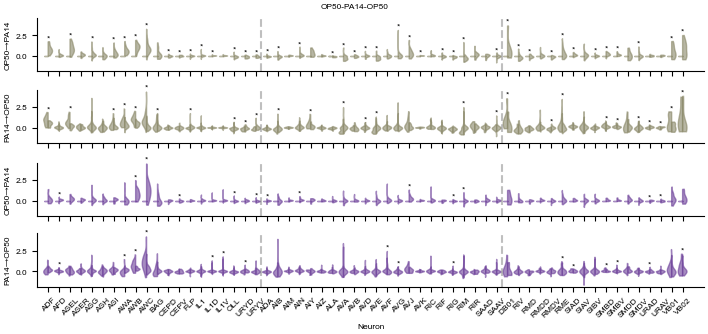

AWB naive OP50→Buffer [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]
AWB naive Buffer→OP50 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]
AWB trained OP50→Buffer [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
AWB trained Buffer→OP50 [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]


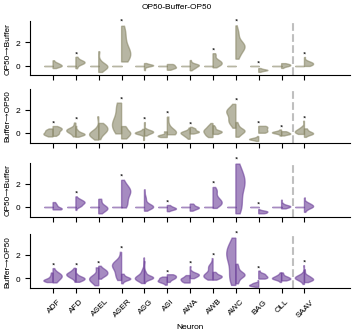

AWB naive Buffer→PA14 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
AWB naive PA14→Buffer [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]
AWB trained Buffer→PA14 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]
AWB trained PA14→Buffer [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]


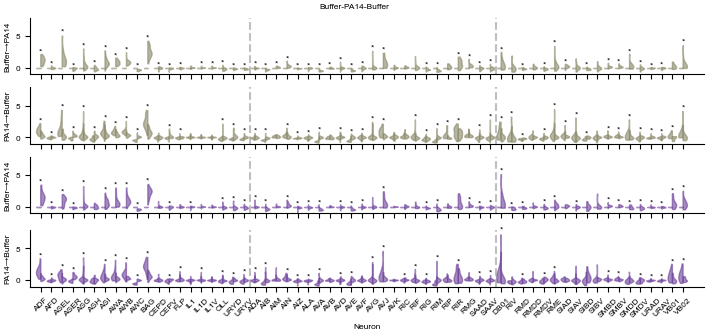

AWB naive Buffer→Buffer-1 [False False False False False False False False False False False False
 False False False False False False]
AWB naive Buffer→Buffer-2 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
AWB trained Buffer→Buffer-1 [False False False False False False False False False False False False
 False False False False]
AWB trained Buffer→Buffer-2 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


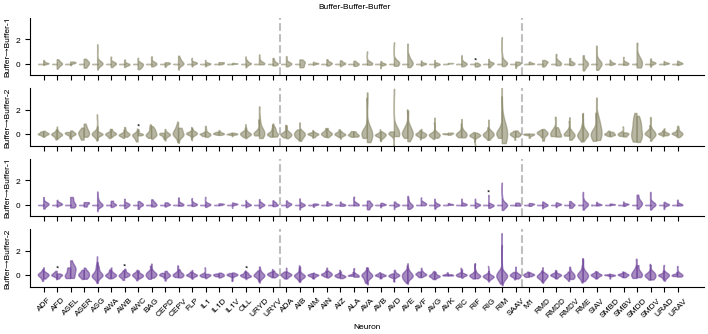

AWB naive OP50→PA14-$\it{gacA(-)}$ [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
AWB naive PA14-$\it{gacA(-)}$→OP50 [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
AWB trained OP50→PA14-$\it{gacA(-)}$ [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True]
AWB trained PA14-$\it{gacA(-)}$→OP50 [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False]


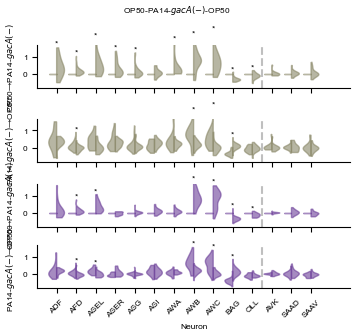

AWB naive OP50→PA14 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True]
AWB naive PA14→OP50 [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False]
AWB trained OP50→PA14 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
AWB trained PA14→OP50 [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]


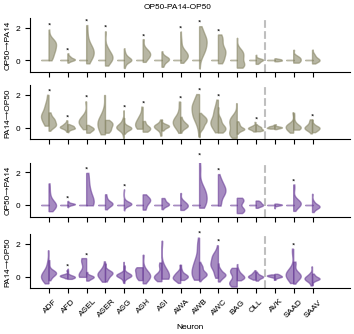

AWB naive OP50→PA14 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
AWB naive PA14→OP50 [False False False False False False False False False False False False
 False False False False False False False False False False False False]
AWB trained OP50→PA14 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
AWB trained PA14→OP50 [False False False False False False False False False False False False
 False False False False False False False False False False False False]


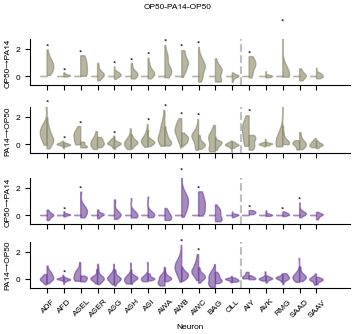

In [35]:
windows = (50,150)
sig_neurs = {}
sign_neurs = {}
for genotype in active_neurons:
    sig_neurs[genotype] = {}
    sign_neurs[genotype] = {}
    for stimulus in active_neurons[genotype]:
        sig_neurs[genotype][stimulus], sign_neurs[genotype][stimulus] = plot_valence_split_violin(active_neurons, genotype=genotype, stimulus=stimulus, periods=windows, measure=measure, save=outputDir + f'Significant_transition_plots_{genotype}_{stimulus}.svg')

In [72]:
outputDir

'Output/2026-01-09/'

In [ ]:
sig_neurs_any  = {}
sign_stims = {}
stim1 = 'OP-PA-OP'
stim2 = 'Buffer-PA-Buffer'
genotypes_filter = ['N2']
window_names = {'OP-PA-OP': ('OP50→PA14','PA14→OP50'), 'Buffer-PA-Buffer': ('Buffer→PA14', 'PA14→Buffer')}
for genotype in sig_neurs:
    sig_neurs_any[genotype] = {}
    for stimulus in sig_neurs[genotype]:
        sig_neurs_any[genotype][stimulus] = set()
        for cond in sig_neurs[genotype][stimulus]:
            for win in sig_neurs[genotype][stimulus][cond]:
                sig_neurs_any[genotype][stimulus].update(sig_neurs[genotype][stimulus][cond][win])

for genotype in genotypes_filter:
    sign_stims[genotype] = {}
    for j, win in enumerate(window_names[stim1]):
        win_name = f'win{j+1}'
        sign_stims[genotype][win_name] = {}
        win_stim2 = window_names[stim2][j]
        print(sign_neurs[genotype][stim1]['naive'].keys())
        for neuron in sign_neurs[genotype][stim1]['naive'][win]:
            sign1 = sign_neurs[genotype][stim1]['naive'][win][neuron]
            sign2 = sign_neurs[genotype][stim2]['naive'][win_stim2].get(neuron, None)
            if sign2 is not None and sign1 == sign2 and (neuron in sig_neurs_any[genotype][stim2] and neuron in sig_neurs_any[genotype][stim1]):
                sign_stims[genotype][win_name][neuron] = 'same'
            elif sign2 is not None and sign1 != sign2 and (neuron in sig_neurs_any[genotype][stim2] and neuron in sig_neurs_any[genotype][stim1]):
                sign_stims[genotype][win_name][neuron] = 'different'
            else:
                sign_stims[genotype][win_name][neuron] = 'ns'

dict_keys(['OP50→PA14', 'PA14→OP50'])
dict_keys(['OP50→PA14', 'PA14→OP50'])


In [ ]:
# Desciring neuron classes:
# modulated by both contexts, changes with learning (FLP, OLL) ungated. context-gated. signs are different. Add the OP-responsive, use the hatmap significance. 
# Are the neurons within the same class more connected than expected by chance?


#Neurons that are more connected are closer to each other in the graph layout. 
# Is the change in buffer context important for its modulation?

# define classes based on significant neurons: PA-responsive (context-independent), PA-responsive (context-dependent), learning modulated, non-responding
neuron_classes = {}
genotype = 'N2'
win = 'OP-PA'
stim1 = 'OP-PA-OP'
stim2 = 'Buffer-PA-Buffer'
for stimulus in significant_neurons_all[genotype]:
    for n in neurons_all[genotype][stimulus]:
        if (n in significant_neurons_all[genotype][stim1] and n not in significant_neurons_all[genotype][stim2])\
              or (n in significant_neurons_all[genotype][stim2] and n not in significant_neurons_all[genotype][stim1]):
            nclass = 'Context-gated'
        elif n in significant_neurons_all[genotype][stim1] and n in significant_neurons_all[genotype][stim2]:
            nclass = 'Context-carrying'
        elif n in sig_neurs_any[genotype][stim1] or n in sig_neurs_any[genotype][stim2]:
            nclass = 'Context-independent'
        else:
            nclass = 'non-responsive'
        if n in significant_neurons_all[genotype][stim1]:# or n in significant_neurons_all[genotype][stim2]:
            nclass += ', learning modulated'
        elif n in significant_neurons_all[genotype][stim2]:
            nclass += ', learning modulated (Buffer)'
        else:
            nclass += ', non-learning modulated'
        neuron_classes[n] = nclass

class_dict = {c:[n for n in neuron_classes if neuron_classes[n]==c] for c in set(neuron_classes.values()) }
class_col = class_dict.keys()
class_col_map = {c: color for c, color in zip(class_col, sns.color_palette("hls", len(class_col)))}

responsive_neurons = [n for n in neuron_classes if not 'non-responsive' in neuron_classes[n]]
nonresponsive_neurons = [n for n in neuron_classes if 'non-responsive' in neuron_classes[n]]

In [ ]:
# modulated by both contexts, changes with learning (FLP, OLL) ungated. context-gated. signs are different. Add the OP-responsive, use the hatmap significance. 
# Are the neurons within the same class more connected than expected by chance?


#Neurons that are more connected are closer to each other in the graph layout. 
# Is the change in buffer context important for its modulation?

# define classes based on significant neurons: PA-responsive (context-independent), PA-responsive (context-dependent), learning modulated, non-responding
## Context-sensitivity: PA responsive, context-gating: different responses in learning vs not learning, learning dependence: modulated in learning vs not learning
neuron_classes = {}
genotype = 'N2'
win = 'OP-PA'
stim1 = 'OP-PA-OP'
stim2 = 'Buffer-PA-Buffer'
neurs = list(set([n for n in active_neurons[genotype][stim1]['naive']] + [n for n in active_neurons[genotype][stim2]['naive']]))
for stimulus in significant_neurons_all[genotype]:
    for n in neurs:
        if (n in significant_neurons_all[genotype][stim1] and n not in significant_neurons_all[genotype][stim2])\
              or (n in significant_neurons_all[genotype][stim2] and n not in significant_neurons_all[genotype][stim1]):
            nclass = 'Context-gated'
        elif n in significant_neurons_all[genotype][stim1] and n in significant_neurons_all[genotype][stim2]:
            nclass = 'Context-ungated'
        else:
            nclass = 'Learning-independent'

        if n in sig_neurs_any[genotype][stim1] and n in sig_neurs_any[genotype][stim2] and sign_stims[genotype]['win1'].get(n,'') == 'same' and sign_stims[genotype]['win2'].get(n,'') == 'same':
            nclass += '-Context-insensitive'
        elif n in sig_neurs_any[genotype][stim1] and n not in sig_neurs_any[genotype][stim2] or n not in sig_neurs_any[genotype][stim1] and n in sig_neurs_any[genotype][stim2]\
            or (n in sig_neurs_any[genotype][stim1] and n in sig_neurs_any[genotype][stim2] and sign_stims[genotype]['win1'].get(n,'') == 'different' or sign_stims[genotype]['win2'].get(n,'') == 'different'):
            nclass += '-Context-sensitive'
        else:
            nclass += '-non-responsive'
        neuron_classes[n] = nclass

class_dict = {c:[n for n in neuron_classes if neuron_classes[n]==c] for c in set(neuron_classes.values()) }
class_col = class_dict.keys()
class_col_map = {c: color for c, color in zip(class_col, sns.color_palette("hls", len(class_col)))}

responsive_neurons = [n for n in neuron_classes if not 'non-responsive' in neuron_classes[n]]
nonresponsive_neurons = [n for n in neuron_classes if 'non-responsive' in neuron_classes[n]]

In [110]:
for j, (cl, ns) in enumerate(class_dict.items()):
    print(f"Class {j+1}: {cl}\n")
    for n in ns:
        print(f"Neuron: {n}, Category: {nn.neurons[n].category}")

Class 1: Learning-independent-non-responsive

Neuron: RMDD, Category: head motor neuron
Class 2: Learning-independent-Context-sensitive

Neuron: RIC, Category: layer 2 interneuron
Neuron: SIBD, Category: sublateral motor neuron
Neuron: SAAD, Category: layer 2 interneuron
Neuron: AVK, Category: layer 2 interneuron
Neuron: RIV, Category: head motor neuron
Neuron: ASER, Category: SN6
Neuron: ASH, Category: SN5
Neuron: RIR, Category: category 4 interneuron
Neuron: RIP, Category: linker to pharynx
Neuron: AIY, Category: layer 3 interneuron
Neuron: RMG, Category: layer 2 interneuron
Neuron: AIM, Category: category 4 interneuron
Neuron: AFD, Category: SN6
Neuron: SIBV, Category: sublateral motor neuron
Neuron: AVF, Category: layer 3 interneuron
Neuron: SIAV, Category: sublateral motor neuron
Neuron: AWC, Category: SN6
Neuron: AIZ, Category: layer 3 interneuron
Neuron: IL1D, Category: SN1
Neuron: IL1, Category: SN1
Class 3: Context-gated-Context-sensitive

Neuron: SMDD, Category: sublateral mo